In [2]:
!pip install yfinance --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
google-api-core 1.33.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 3.19.4 which is incompatible.
gcsfs 2022.5.0 requires fsspec==2022.5.0, but you have fsspec 2022.8.2 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is in

In [3]:
import warnings
warnings.filterwarnings("ignore")
import time
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (22,5)

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from datetime import date

In [4]:
data = yf.Ticker("GOOGL")
data_hist = data.history(period="max")
data_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.493464,2.594698,2.392727,2.501941,893181924,0.0,0.0
2004-08-20 00:00:00-04:00,2.518648,2.719870,2.505931,2.700670,456686856,0.0,0.0
2004-08-23 00:00:00-04:00,2.761511,2.829582,2.719122,2.727849,365122512,0.0,0.0
2004-08-24 00:00:00-04:00,2.773729,2.782706,2.582480,2.614895,304946748,0.0,0.0
2004-08-25 00:00:00-04:00,2.617140,2.692941,2.590210,2.643072,183772044,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-09 00:00:00-05:00,173.960007,176.259995,173.649994,175.369995,25389600,0.2,0.0
2024-12-10 00:00:00-05:00,182.850006,186.360001,181.050003,185.169998,54813000,0.0,0.0
2024-12-11 00:00:00-05:00,185.309998,195.610001,184.850006,195.399994,67894100,0.0,0.0


In [5]:
print(f'{data_hist.shape[0]} rows and {data_hist.shape[1]} columns')

5116 rows and 7 columns


In [6]:
data_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

Date
2004-08-19 00:00:00-04:00    NaN
2004-08-20 00:00:00-04:00    1.0
2004-08-23 00:00:00-04:00    1.0
2004-08-24 00:00:00-04:00    0.0
2004-08-25 00:00:00-04:00    1.0
                            ... 
2024-12-09 00:00:00-05:00    1.0
2024-12-10 00:00:00-05:00    1.0
2024-12-11 00:00:00-05:00    1.0
2024-12-12 00:00:00-05:00    0.0
2024-12-13 00:00:00-05:00    0.0
Name: Close, Length: 5116, dtype: float64

In [7]:
data_hist["Target"] = data_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [8]:
df = data_hist.copy()
df = df.shift(1)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Target
Date,,,,,,,,
2004-08-19 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-20 00:00:00-04:00,2.493464,2.594698,2.392727,2.501941,893181924.0,0.0,0.0,NaN
2004-08-23 00:00:00-04:00,2.518648,2.719870,2.505931,2.700670,456686856.0,0.0,0.0,1.0
2004-08-24 00:00:00-04:00,2.761511,2.829582,2.719122,2.727849,365122512.0,0.0,0.0,1.0
2004-08-25 00:00:00-04:00,2.773729,2.782706,2.582480,2.614895,304946748.0,0.0,0.0,0.0


In [9]:
predictors = ["Close", "Volume", "Open", "High", "Low"]

df = df[["Open", "High", "Low", "Close", "Volume",'Target']].iloc[2:]

df.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2004-08-23 00:00:00-04:00,2.518648,2.719870,2.505931,2.700670,456686856.0,1.0
2004-08-24 00:00:00-04:00,2.761511,2.829582,2.719122,2.727849,365122512.0,1.0
2004-08-25 00:00:00-04:00,2.773729,2.782706,2.582480,2.614895,304946748.0,0.0
2004-08-26 00:00:00-04:00,2.617140,2.692941,2.590210,2.643072,183772044.0,1.0
2004-08-27 00:00:00-04:00,2.616890,2.691694,2.609659,2.690696,141897960.0,1.0


In [10]:
weekly_mean = df.rolling(7).mean()
quarterly_mean = df.rolling(90).mean()
annual_mean = df.rolling(365).mean()

weekly_trend = df.shift(1).rolling(7).mean()["Target"]

df["weekly_mean"] = weekly_mean["Close"] / df["Close"]
df["quarterly_mean"] = quarterly_mean["Close"] / df["Close"]
df["annual_mean"] = annual_mean["Close"] / df["Close"]

df["annual_weekly_mean"] = df["annual_mean"] / df["weekly_mean"]
df["annual_quarterly_mean"] = df["annual_mean"] / df["quarterly_mean"]
df["weekly_trend"] = weekly_trend

df["open_close_ratio"] = df["Open"] / df["Close"]

df["high_close_ratio"] = df["High"] / df["Close"]

df["low_close_ratio"] = df["Low"] / df["Close"]

In [12]:
df.head()

,Open,High,Low,Close,Volume,Target,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,,,
2004-08-23 00:00:00-04:00,2.518648,2.719870,2.505931,2.700670,456686856.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.932601,1.007109,0.927892
2004-08-24 00:00:00-04:00,2.761511,2.829582,2.719122,2.727849,365122512.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.012340,1.037294,0.996801
2004-08-25 00:00:00-04:00,2.773729,2.782706,2.582480,2.614895,304946748.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.060742,1.064175,0.987604
2004-08-26 00:00:00-04:00,2.617140,2.692941,2.590210,2.643072,183772044.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.990189,1.018868,0.980000
2004-08-27 00:00:00-04:00,2.616890,2.691694,2.609659,2.690696,141897960.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.972570,1.000371,0.969882


In [13]:
for i in range(len(df.columns)):
    if df[df.columns[i]].isnull().sum()>0:
        print(f'Column {i} {df.columns[i]} null values : {round(df[df.columns[i]].isnull().sum()/df.shape[0]*100,2)}%')

Column 6 weekly_mean null values : 0.12%
Column 7 quarterly_mean null values : 1.74%
Column 8 annual_mean null values : 7.12%
Column 9 annual_weekly_mean null values : 7.12%
Column 10 annual_quarterly_mean null values : 7.12%
Column 11 weekly_trend null values : 0.14%


In [14]:
df.fillna(0, inplace=True)

In [15]:
df.isnull().sum()

Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
Target                   0
weekly_mean              0
quarterly_mean           0
annual_mean              0
annual_weekly_mean       0
annual_quarterly_mean    0
weekly_trend             0
open_close_ratio         0
high_close_ratio         0
low_close_ratio          0
dtype: int64

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse

In [17]:
df

,Open,High,Low,Close,Volume,Target,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,,,
2004-08-23 00:00:00-04:00,2.518648,2.719870,2.505931,2.700670,456686856.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.932601,1.007109,0.927892
2004-08-24 00:00:00-04:00,2.761511,2.829582,2.719122,2.727849,365122512.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.012340,1.037294,0.996801
2004-08-25 00:00:00-04:00,2.773729,2.782706,2.582480,2.614895,304946748.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.060742,1.064175,0.987604
2004-08-26 00:00:00-04:00,2.617140,2.692941,2.590210,2.643072,183772044.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990189,1.018868,0.980000
2004-08-27 00:00:00-04:00,2.616890,2.691694,2.609659,2.690696,141897960.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.972570,1.000371,0.969882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09 00:00:00-05:00,171.833070,174.879581,171.663266,174.510010,21462400.0,1.0,0.983450,0.947415,0.864013,0.878553,0.911968,0.571429,0.984660,1.002118,0.983687
2024-12-10 00:00:00-05:00,173.960007,176.259995,173.649994,175.369995,25389600.0,1.0,0.983787,0.943088,0.860645,0.874829,0.912581,0.571429,0.991960,1.005075,0.990192
2024-12-11 00:00:00-05:00,182.850006,186.360001,181.050003,185.169998,54813000.0,1.0,0.944383,0.894311,0.816080,0.864140,0.912523,0.571429,0.987471,1.006427,0.977750


In [18]:
predictors  = ['Open', 'High','Low','Close','weekly_mean','quarterly_mean','annual_mean','annual_weekly_mean','annual_quarterly_mean','weekly_trend','open_close_ratio','high_close_ratio','low_close_ratio']

In [20]:
NN_df = df[predictors]

In [110]:
NN_df.head()

,Open,High,Low,Close,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,
2004-08-23 00:00:00-04:00,2.518648,2.719870,2.505931,2.700670,0.0,0.0,0.0,0.0,0.0,0.0,0.932601,1.007109,0.927892
2004-08-24 00:00:00-04:00,2.761511,2.829582,2.719122,2.727849,0.0,0.0,0.0,0.0,0.0,0.0,1.012340,1.037294,0.996801
2004-08-25 00:00:00-04:00,2.773729,2.782706,2.582480,2.614895,0.0,0.0,0.0,0.0,0.0,0.0,1.060742,1.064175,0.987604
2004-08-26 00:00:00-04:00,2.617140,2.692941,2.590210,2.643072,0.0,0.0,0.0,0.0,0.0,0.0,0.990189,1.018868,0.980000
2004-08-27 00:00:00-04:00,2.616890,2.691694,2.609659,2.690696,0.0,0.0,0.0,0.0,0.0,0.0,0.972570,1.000371,0.969882


In [21]:
scaler = MinMaxScaler()
scaler.fit(NN_df[NN_df.columns])
NN_df[NN_df.columns] = scaler.transform(NN_df[NN_df.columns])

In [22]:
NN_df

,Open,High,Low,Close,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,
2004-08-23 00:00:00-04:00,0.000236,0.000948,0.000206,0.001073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072369,0.063719,0.415891
2004-08-24 00:00:00-04:00,0.001497,0.001516,0.001332,0.001214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.511416,0.334254,0.974084
2004-08-25 00:00:00-04:00,0.001561,0.001273,0.000610,0.000628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777920,0.575175,0.899585
2004-08-26 00:00:00-04:00,0.000747,0.000808,0.000651,0.000774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.389449,0.169106,0.837990
2004-08-27 00:00:00-04:00,0.000746,0.000802,0.000754,0.001021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.292438,0.003323,0.756032
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09 00:00:00-05:00,0.879669,0.892629,0.894069,0.891709,0.869010,0.593512,0.424482,0.460292,0.596232,0.571429,0.359009,0.018981,0.867858
2024-12-10 00:00:00-05:00,0.890717,0.899779,0.904567,0.896167,0.869308,0.590801,0.422827,0.458341,0.596633,0.571429,0.399201,0.045485,0.920552
2024-12-11 00:00:00-05:00,0.936892,0.952091,0.943670,0.946969,0.834489,0.560244,0.400933,0.452741,0.596594,0.571429,0.374485,0.057599,0.819765


In [23]:
def df_to_X_y2(df, window_size=13):

    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [24]:
X, y = df_to_X_y2(NN_df)

print(f'X shape {X.shape} y shape {y.shape}')
print(f'There are {X.shape[0]} samples, {X.shape[1]} timesteps and {X.shape[2]} features in the our data')

X shape (5101, 13, 13) y shape (5101,)
There are 5101 samples, 13 timesteps and 13 features in the our data


In [25]:
X

array([[[2.35715511e-04, 9.47933871e-04, 2.05545911e-04, ...,
         7.23685891e-02, 6.37194455e-02, 4.15891082e-01],
        [1.49716926e-03, 1.51617523e-03, 1.33209355e-03, ...,
         5.11416006e-01, 3.34254378e-01, 9.74084234e-01],
        [1.56062913e-03, 1.27338216e-03, 6.10049804e-04, ...,
         7.77919534e-01, 5.75175310e-01, 8.99585398e-01],
        ...,
        [2.27942408e-04, 0.00000000e+00, 5.00669326e-05, ...,
         4.95221151e-01, 1.55036597e-01, 9.44109920e-01],
        [2.35714969e-04, 3.35803762e-05, 8.82811581e-05, ...,
         4.12574415e-01, 3.70589076e-02, 8.42903130e-01],
        [2.00745161e-04, 1.66596539e-04, 2.05545320e-04, ...,
         3.59506955e-01, 6.39546770e-02, 8.57468814e-01]],

       [[1.49716926e-03, 1.51617523e-03, 1.33209355e-03, ...,
         5.11416006e-01, 3.34254378e-01, 9.74084234e-01],
        [1.56062913e-03, 1.27338216e-03, 6.10049804e-04, ...,
         7.77919534e-01, 5.75175310e-01, 8.99585398e-01],
        [7.47290430e-04, 

In [26]:
y

array([4.32573679e-04, 3.12128382e-04, 9.63571759e-04, ...,
       9.36891913e-01, 9.49669315e-01, 1.00000000e+00])

In [27]:
y = np.squeeze(scaler.fit_transform(np.expand_dims(y, axis=1)))

In [28]:
threshold = int(X.shape[0] * 0.75)  

X_train, y_train = X[:threshold], y[:threshold]

X_test, y_test = X[threshold:], y[threshold:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3825, 13, 13)
y_train shape: (3825,)
X_test shape: (1276, 13, 13)
y_test shape: (1276,)


In [29]:
model = Sequential()

model.add(InputLayer((X_train.shape[1], X_train.shape[2])))

model.add(GRU(64))

model.add(Dense(8, 'relu'))

model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                15168     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 15,697
Trainable params: 15,697
Non-trainable params: 0
_________________________________________________________________


In [30]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [32]:
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [33]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=callback)

Epoch 1/100
120/120 [==============================] - 4s 6ms/step - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 2/100
120/120 [==============================] - 0s 3ms/step - loss: 2.0156e-05 - root_mean_squared_error: 0.0045 - val_loss: 6.9822e-04 - val_root_mean_squared_error: 0.0264
Epoch 3/100
120/120 [==============================] - 0s 3ms/step - loss: 1.2125e-05 - root_mean_squared_error: 0.0035 - val_loss: 8.3682e-04 - val_root_mean_squared_error: 0.0289
Epoch 4/100
120/120 [==============================] - 0s 4ms/step - loss: 1.1033e-05 - root_mean_squared_error: 0.0033 - val_loss: 6.1294e-04 - val_root_mean_squared_error: 0.0248
Epoch 5/100
120/120 [==============================] - 0s 4ms/step - loss: 1.0108e-05 - root_mean_squared_error: 0.0032 - val_loss: 6.2348e-04 - val_root_mean_squared_error: 0.0250
Epoch 6/100
120/120 [==============================] - 0s 4ms/step - loss: 1.0355e-05 - root_mean_squar

In [34]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

,Test Predictions,Actuals
0,0.324976,0.331710
1,0.323751,0.330232
2,0.321588,0.326279
3,0.319532,0.323144
4,0.319235,0.324115
...,...,...
1271,0.829928,0.879631
1272,0.838291,0.890682
1273,0.840872,0.936872
1274,0.858945,0.949654


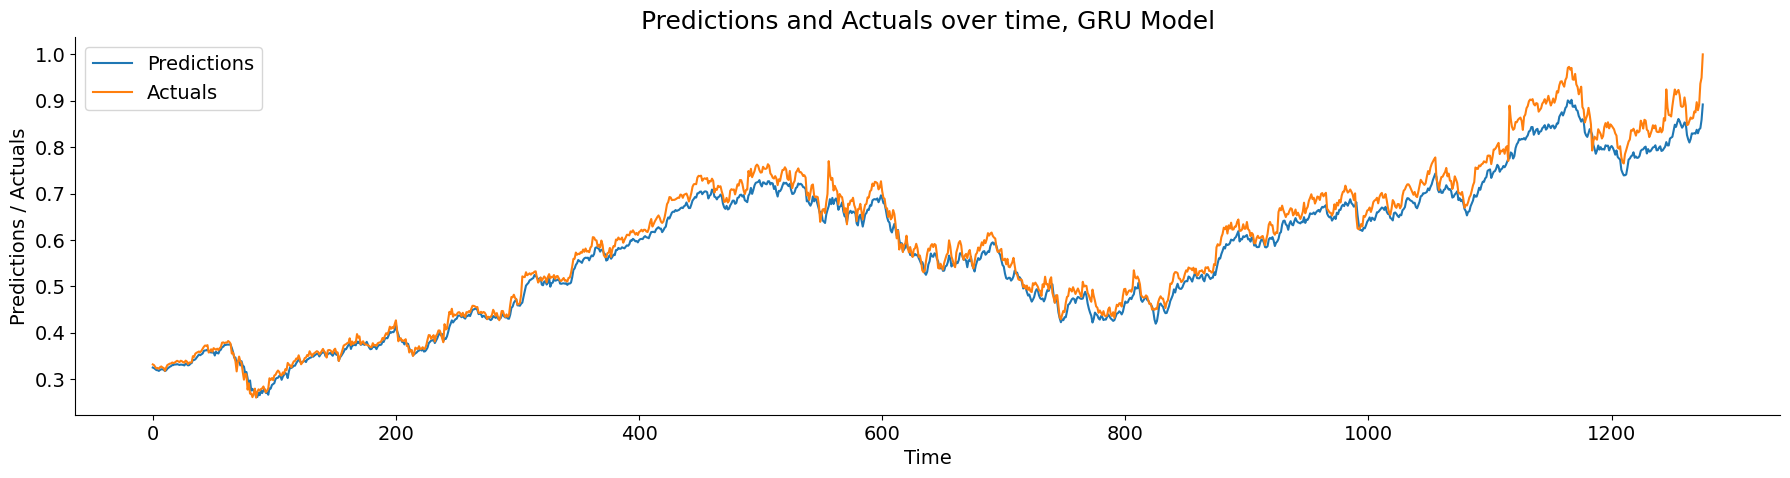

In [35]:
plt.plot(test_results['Test Predictions']) 
plt.plot(test_results['Actuals'])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(['Predictions', 'Actuals'])
plt.ylabel('Predictions / Actuals')
plt.xlabel('Time')
plt.title('Predictions and Actuals over time, GRU Model', fontsize=18)
plt.show()

In [36]:
print('MSE of the GRU model :', round(mse(test_results['Test Predictions'], test_results['Actuals']),6))

MSE of the GRU model : 0.000764
